In [52]:
from utils import make_need_tree,visualize_tree,make_storage,make_task_list
# visual test_tasks with gantt chart
import plotly.express as px
import pandas as pd
import json

In [53]:
name='strawberry cake'

In [54]:
storage = make_storage()
tasks=make_task_list(name,storage)
tasks

[{'id': 1,
  'name': 'corn',
  'dependencies': [],
  'duration': 300,
  'source': 'Field',
  'machine_id': None},
 {'id': 2,
  'name': 'soybean',
  'dependencies': [],
  'duration': 1200,
  'source': 'Field',
  'machine_id': None},
 {'id': 3,
  'name': 'soybean',
  'dependencies': [],
  'duration': 1200,
  'source': 'Field',
  'machine_id': None},
 {'id': 4,
  'name': 'cow feed',
  'dependencies': [1, 2, 3],
  'duration': 600,
  'source': 'Feed Mill',
  'machine_id': None},
 {'id': 5,
  'name': 'milk',
  'dependencies': [1, 2, 3, 4],
  'duration': 3600,
  'source': 'Cow',
  'machine_id': None},
 {'id': 6,
  'name': 'cream',
  'dependencies': [1, 2, 3, 4, 5],
  'duration': 1200,
  'source': 'Dairy',
  'machine_id': None},
 {'id': 7,
  'name': 'strawberry',
  'dependencies': [],
  'duration': 28800,
  'source': 'Field',
  'machine_id': None},
 {'id': 8,
  'name': 'strawberry',
  'dependencies': [],
  'duration': 28800,
  'source': 'Field',
  'machine_id': None},
 {'id': 9,
  'name': 'whe

In [55]:
# number of machines
sources={
    'Bakery':1, 'Chicken':2, 'Feed Mill':1, 'Field':4, 'Raspberry bush':1,'Sugar Mill':1,'Cake Oven':1,
    'Cherry tree':2,'Cow':6,'BBQ Grill':1,'Dairy':1
}
machines ={}
# make machines is: key is same as sources, value is a list of machine_id
# machine_id must be unique from other machines
count  = 0
for key,value in sources.items():
    machines[key]=list(range(count,count+value))
    count+=value
machines

{'Bakery': [0],
 'Chicken': [1, 2],
 'Feed Mill': [3],
 'Field': [4, 5, 6, 7],
 'Raspberry bush': [8],
 'Sugar Mill': [9],
 'Cake Oven': [10],
 'Cherry tree': [11, 12],
 'Cow': [13, 14, 15, 16, 17, 18],
 'BBQ Grill': [19],
 'Dairy': [20]}

In [56]:
# function to check if task b depends on task a
def check_dependency(task_a_pos,task_b_pos):
    """check if task b is in the dependencies of task a
    task_a_pos: position of task a in tasks list
    task_b_pos: position of task b in tasks list
    
    return: True if task b depends on task a, False otherwise
    """
    task_a = tasks[task_a_pos]
    task_b = tasks[task_b_pos]
    return task_b['id'] in task_a['dependencies']

In [57]:
import random

def make_chromosome(tasks,machines):
    """make a chromosome from tasks and machines
    tasks: list of task
    machines: dictionary of machines
    
    return: a chromosome (list of tuple (id,machine_id))
    id is the position of the task in the task list
    machine_id is the id of the machine
    the order of the tuple is the order of the task
    """
    chromosome=[]
    for i in range(len(tasks)):
        task=tasks[i]
        machine_id=random.choice(machines[task['source']])
        chromosome.append((i,machine_id))
    # # random shuffle the chromosome
    for i in range(len(chromosome)):
        for j in range(i+1,len(chromosome)):
            if check_dependency(i,j) and random.random()<0.5:
                chromosome[i],chromosome[j]=chromosome[j],chromosome[i]
    return chromosome

def chromosome_to_task_list(chromosome):
    """convert a chromosome to a task list
    chromosome: a chromosome
    
    return: a task list
    """
    task_list=[]
    for task_id,machine_id in chromosome:
        temp_task = tasks[task_id].copy()
        temp_task['machine_id']=machine_id
        task_list.append(temp_task)
    return task_list
    
chromosome = make_chromosome(tasks,machines)
test_tasks=chromosome_to_task_list(chromosome)

In [58]:
# calc start and end time for each task
machine_queue={}
for key in machines.keys():
    for machine_id in machines[key]:
        machine_queue[machine_id]=[]

for task in test_tasks:
    start_time = 0
    if len(machine_queue[task['machine_id']]):
        start_time=machine_queue[task['machine_id']][-1]['end_time']
    else:
        start_time=0
    if len(task['dependencies']):
        for dependency_task_id in task['dependencies']:
            dependency_task = [t for t in test_tasks if t['id']==dependency_task_id][0]
            dependency_task_end_time = dependency_task['end_time']
            if dependency_task_end_time>start_time:
                start_time=dependency_task_end_time
    task['start_time']=start_time
    task['end_time']=start_time+task['duration']
    machine_queue[task['machine_id']].append(task)

In [59]:
df = pd.DataFrame(test_tasks)
# task is source + machine_id
df['task']=df['source']+' '+df['machine_id'].astype(str)
df['start_time'] = pd.to_datetime('today')+pd.to_timedelta(df['start_time'],unit='s')
df['end_time'] = pd.to_datetime('today')+pd.to_timedelta(df['end_time'],unit='s')
df.head()

,id,name,dependencies,duration,source,machine_id,start_time,end_time,task
0,1,corn,[],300,Field,6,2024-01-04 00:54:11.993023,2024-01-04 00:59:11.995059,Field 6
1,2,soybean,[],1200,Field,7,2024-01-04 00:54:11.993023,2024-01-04 01:14:11.995059,Field 7
2,3,soybean,[],1200,Field,4,2024-01-04 00:54:11.993023,2024-01-04 01:14:11.995059,Field 4
3,4,cow feed,"[1, 2, 3]",600,Feed Mill,3,2024-01-04 01:14:11.993023,2024-01-04 01:24:11.995059,Feed Mill 3
4,5,milk,"[1, 2, 3, 4]",3600,Cow,13,2024-01-04 01:24:11.993023,2024-01-04 02:24:11.995059,Cow 13


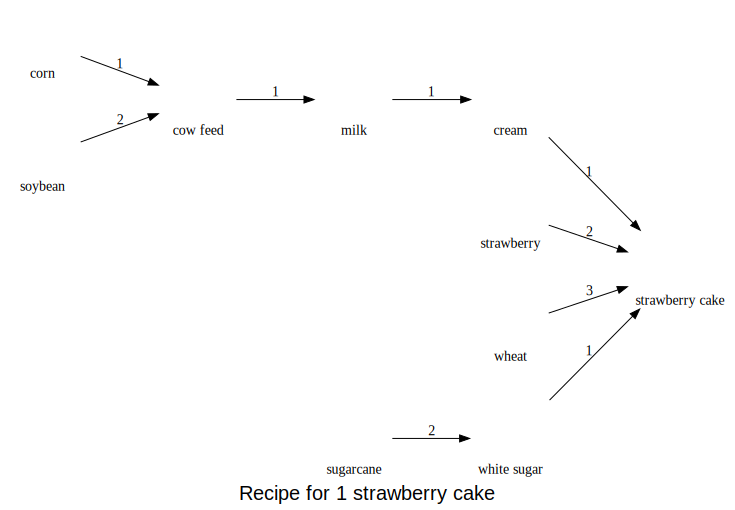

In [60]:

fig = px.timeline(df, x_start="start_time", x_end="end_time", y="task", color="name",hover_name='name', 
                    hover_data={'id':True,'duration':True,'start_time':False,'end_time':False,'task':False,'name':False,'source':False,'machine_id':False,'dependencies':True})
fig.update_yaxes(autorange="reversed")
fig.update_layout(title_text='Plan for '+name,title_x=0.5)
fig.show()
tree = make_need_tree(name,1)
visualize_tree(tree)